In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, log_loss, brier_score_loss, classification_report,confusion_matrix


In [2]:
df = pd.read_csv('oneday_df.csv')

In [35]:
sparse = ['hour', 'imp_content_position', 'imp_page_id', 'imp_ref_page_id', 
          'imp_ref_source', 'user_sex', 'user_age', 'content_category_id']
dense = ['user_following_cnt', 'user_bunpay_count', 'owner_grade', 'owner_item_count',
         'owner_interest', 'owner_follower_cnt', 'owner_bunpay_count', 'content_price',
        'content_emergency_cnt', 'content_comment_cnt', 'content_interest', 'content_pfavcnt']
features = sparse + dense

In [4]:
for s in sparse:
    df[s] = df[s].fillna('-1')
    df[s] = preprocessing.LabelEncoder().fit_transform(df[s])
for d in dense:
    df[d] = df[d].fillna(0)
# Normalization
# df[dense] = preprocessing.MinMaxScaler(feature_range = (0, 1)).fit_transform(df[dense])

In [5]:
df = df[features + ['label']]

In [6]:
print('data shape:', df.shape)
print('Overall CTR:', round(len(df[df['label'] == 1])/len(df), 4))

data shape: (3077366, 21)
Overall CTR: 0.0314


### LightGBM

#### sampling n = 1m

In [15]:
data = df.sample(n=1000000)
train, test = train_test_split(data, test_size = 0.2)
train, valid = train_test_split(train, test_size = 0.2)
train_data = lgb.Dataset(train[features], label=train['label'], feature_name = features, categorical_feature=sparse)
validation_data = lgb.Dataset(valid[features], label=valid['label'], feature_name = features, categorical_feature=sparse)
test_data = lgb.Dataset(test[features], label=test['label'], feature_name = features, categorical_feature=sparse)

In [16]:
param = {
    'objective': 'binary', 
    'metric': ['auc', 'binary_logloss']
}

num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.634115	valid_0's binary_logloss: 0.138678
[2]	valid_0's auc: 0.640774	valid_0's binary_logloss: 0.137901
[3]	valid_0's auc: 0.647045	valid_0's binary_logloss: 0.137286
[4]	valid_0's auc: 0.651074	valid_0's binary_logloss: 0.136794
[5]	valid_0's auc: 0.651595	valid_0's binary_logloss: 0.136409
[6]	valid_0's auc: 0.654329	valid_0's binary_logloss: 0.136065
[7]	valid_0's auc: 0.65512	valid_0's binary_logloss: 0.135821
[8]	valid_0's auc: 0.655523	valid_0's binary_logloss: 0.135611
[9]	valid_0's auc: 0.655212	valid_0's binary_logloss: 0.135459
[10]	valid_0's auc: 0.656378	valid_0's binary_logloss: 0.135291


In [22]:
lgbm_pred = bst.predict(np.array(test[features]))
print('log_loss:', log_loss(test['label'], lgbm_pred.tolist()))
print('brier_score_loss:', brier_score_loss(test['label'], lgbm_pred))
print('============================================================')
print('classification report:')
print(classification_report(test['label'], lgbm_pred.round()))
print('confusion_matrix:')
print(confusion_matrix(test['label'], lgbm_pred.round()))

log_loss: 0.13646385192475313
brier_score_loss: 0.030467354330201608
classification report:


/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    193637
           1       0.00      0.00      0.00      6363

    accuracy                           0.97    200000
   macro avg       0.48      0.50      0.49    200000
weighted avg       0.94      0.97      0.95    200000

confusion_matrix:
[[193637      0]
 [  6363      0]]


In [9]:
from scipy.stats import entropy
def rig(p, q):
    return (entropy(p, base=2) - entropy(p, q, base=2))/entropy(p, base=2)

In [41]:
print('RIG:', rig(lgbm_pred, [len(test[test['label'] == 1])/len(test)]*len(lgbm_pred)))

RIG: 0.9946347616408873


In [42]:
len(test[test['label'] == 1])/len(test)

0.031815

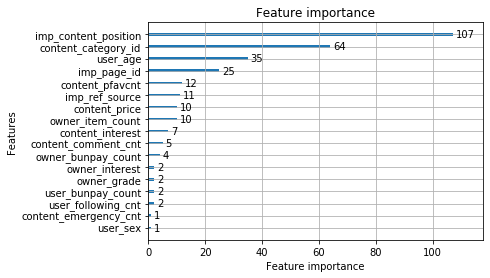

In [45]:
lgb.plot_importance(bst)

#### sampling n = 3m

In [48]:
data = df.sample(n=3000000)
train, test = train_test_split(data, test_size = 0.2)
train, valid = train_test_split(train, test_size = 0.2)
train_data = lgb.Dataset(train[features], label=train['label'], feature_name = features, categorical_feature=sparse)
validation_data = lgb.Dataset(valid[features], label=valid['label'], feature_name = features, categorical_feature=sparse)
test_data = lgb.Dataset(test[features], label=test['label'], feature_name = features, categorical_feature=sparse)

param = {
    'objective': 'binary', 
    'metric': ['auc', 'binary_logloss']
}

num_round = 10
bst2 = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

lgbm_pred2 = bst2.predict(np.array(test[features]))
print('log_loss:', log_loss(test['label'], lgbm_pred2.tolist()))
print('brier_score_loss:', brier_score_loss(test['label'], lgbm_pred2))
print('RIG:', rig(lgbm_pred2, [len(test[test['label'] == 1])/len(test)]*len(lgbm_pred2)))
print('============================================================')
print('classification report:')
print(classification_report(test['label'], lgbm_pred2.round()))
print('confusion_matrix:')
print(confusion_matrix(test['label'], lgbm_pred2.round()))

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.648373	valid_0's binary_logloss: 0.139034
[2]	valid_0's auc: 0.655793	valid_0's binary_logloss: 0.138201
[3]	valid_0's auc: 0.658861	valid_0's binary_logloss: 0.137564
[4]	valid_0's auc: 0.661382	valid_0's binary_logloss: 0.137048
[5]	valid_0's auc: 0.662196	valid_0's binary_logloss: 0.136637
[6]	valid_0's auc: 0.663307	valid_0's binary_logloss: 0.136315
[7]	valid_0's auc: 0.663966	valid_0's binary_logloss: 0.13603
[8]	valid_0's auc: 0.665636	valid_0's binary_logloss: 0.135775
[9]	valid_0's auc: 0.666545	valid_0's binary_logloss: 0.135569
[10]	valid_0's auc: 0.667735	valid_0's binary_logloss: 0.135385
log_loss: 0.13349483632229114
brier_score_loss: 0.02971120252966725
RIG: 0.9954232968395924
classification report:


/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    581389
           1       0.00      0.00      0.00     18611

    accuracy                           0.97    600000
   macro avg       0.48      0.50      0.49    600000
weighted avg       0.94      0.97      0.95    600000

confusion_matrix:
[[581389      0]
 [ 18611      0]]


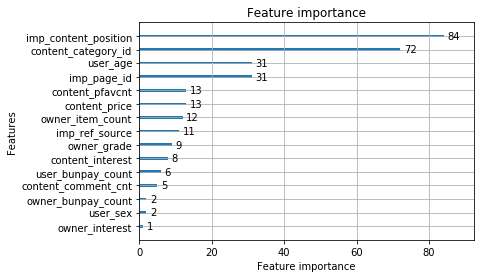

In [49]:
lgb.plot_importance(bst2)

#### under-sampling  
label 1: 0 = 1: 9

In [50]:
n = 80000
data = pd.concat([df[df['label'] == 1].sample(n=n), df[df['label'] == 0].sample(n=n*9)])
train, test = train_test_split(data, test_size = 0.2)
train, valid = train_test_split(train, test_size = 0.2)
train_data = lgb.Dataset(train[features], label=train['label'], feature_name = features, categorical_feature=sparse)
validation_data = lgb.Dataset(valid[features], label=valid['label'], feature_name = features, categorical_feature=sparse)
test_data = lgb.Dataset(test[features], label=test['label'], feature_name = features, categorical_feature=sparse)

param = {
    'objective': 'binary', 
    'metric': ['auc', 'binary_logloss']
}

num_round = 10
bst3 = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

lgbm_pred3 = bst3.predict(np.array(test[features]))
print('log_loss:', log_loss(test['label'], lgbm_pred3.tolist()))
print('brier_score_loss:', brier_score_loss(test['label'], lgbm_pred3))
print('RIG:', rig(lgbm_pred3, [len(test[test['label'] == 1])/len(test)]*len(lgbm_pred3)))
print('============================================================')
print('classification report:')
print(classification_report(test['label'], lgbm_pred3.round()))
print('confusion_matrix:')
print(confusion_matrix(test['label'], lgbm_pred3.round()))

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.64245	valid_0's binary_logloss: 0.320218
[2]	valid_0's auc: 0.654785	valid_0's binary_logloss: 0.317963
[3]	valid_0's auc: 0.657561	valid_0's binary_logloss: 0.316135
[4]	valid_0's auc: 0.659788	valid_0's binary_logloss: 0.314679
[5]	valid_0's auc: 0.660853	valid_0's binary_logloss: 0.313448
[6]	valid_0's auc: 0.661692	valid_0's binary_logloss: 0.31246
[7]	valid_0's auc: 0.662105	valid_0's binary_logloss: 0.311679
[8]	valid_0's auc: 0.663097	valid_0's binary_logloss: 0.310958
[9]	valid_0's auc: 0.664346	valid_0's binary_logloss: 0.310312
[10]	valid_0's auc: 0.66569	valid_0's binary_logloss: 0.309751
log_loss: 0.3109473905500593
brier_score_loss: 0.08707321431828136
RIG: 0.9958488139467061
classification report:


/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    144044
           1       0.00      0.00      0.00     15956

    accuracy                           0.90    160000
   macro avg       0.45      0.50      0.47    160000
weighted avg       0.81      0.90      0.85    160000

confusion_matrix:
[[144044      0]
 [ 15956      0]]


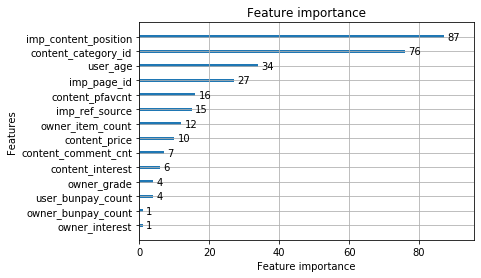

In [51]:
lgb.plot_importance(bst3)

#### negative sampling

In [52]:
import random

n = 3000000
data = df.sample(n=n)
train, test = train_test_split(data, test_size = 0.2)
print('label 1 proportion before negative sampling:', len(train[train['label'] == 1])/len(train))
one_index = train[train['label'] == 1].index
rand_index = random.sample(range(len(one_index)), round(len(one_index)*0.2))
train.loc[train.index[rand_index], 'label'] = 0
print('label 1 proportion after negative sampling:', len(train[train['label'] == 1])/len(train))
print('============================================================')
train, valid = train_test_split(train, test_size = 0.2)
train_data = lgb.Dataset(train[features], label=train['label'], feature_name = features, categorical_feature=sparse)
validation_data = lgb.Dataset(valid[features], label=valid['label'], feature_name = features, categorical_feature=sparse)
test_data = lgb.Dataset(test[features], label=test['label'], feature_name = features, categorical_feature=sparse)

param = {
    'objective': 'binary', 
    'metric': ['auc', 'binary_logloss']
}

num_round = 10
bst4 = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

lgbm_pred4 = bst4.predict(np.array(test[features]))
print('log_loss:', log_loss(test['label'], lgbm_pred4.tolist()))
print('brier_score_loss:', brier_score_loss(test['label'], lgbm_pred4))
print('RIG:', rig(lgbm_pred4, [len(test[test['label'] == 1])/len(test)]*len(lgbm_pred4)))
print('============================================================')
print('classification report:')
print(classification_report(test['label'], lgbm_pred4.round()))
print('confusion_matrix:')
print(confusion_matrix(test['label'], lgbm_pred4.round()))

label 1 proportion before negative sampling: 0.03151958333333333


/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


label 1 proportion after negative sampling: 0.03132541666666667


/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.646991	valid_0's binary_logloss: 0.138766
[2]	valid_0's auc: 0.653852	valid_0's binary_logloss: 0.137957
[3]	valid_0's auc: 0.658229	valid_0's binary_logloss: 0.137319
[4]	valid_0's auc: 0.661286	valid_0's binary_logloss: 0.136791
[5]	valid_0's auc: 0.661975	valid_0's binary_logloss: 0.136383
[6]	valid_0's auc: 0.662958	valid_0's binary_logloss: 0.13606
[7]	valid_0's auc: 0.663744	valid_0's binary_logloss: 0.13578
[8]	valid_0's auc: 0.66499	valid_0's binary_logloss: 0.135526
[9]	valid_0's auc: 0.666467	valid_0's binary_logloss: 0.135308
[10]	valid_0's auc: 0.666883	valid_0's binary_logloss: 0.135147
log_loss: 0.13320415083098716
brier_score_loss: 0.02963809989091692
RIG: 0.9954182598032792
classification report:


/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    581430
           1       0.00      0.00      0.00     18570

    accuracy                           0.97    600000
   macro avg       0.48      0.50      0.49    600000
weighted avg       0.94      0.97      0.95    600000

confusion_matrix:
[[581430      0]
 [ 18570      0]]


In [34]:
print('log_loss:', log_loss([0.3]*len(lgbm_pred4), lgbm_pred4.tolist()))


NameError: name 'lgbm_pred4' is not defined

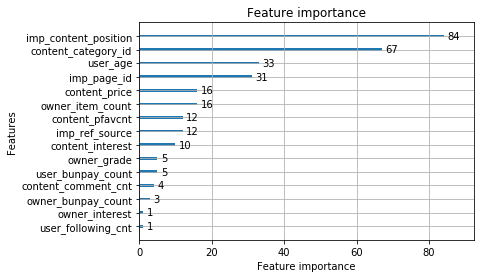

In [53]:
lgb.plot_importance(bst4)

### XGBoost

In [7]:
data = df.sample(n=3000000)
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
import random
from sklearn.model_selection import RandomizedSearchCV

param_space = {
    'n_estimators': range(2, 7), 
    'max_depth': range(3, 7),
    'scale_pos_weight': range(1, 5),
    'learning_rate': [0.1, 0.01, 0.001]
}


xgb = XGBClassifier(objective='binary:logistic',
                    n_jobs=-1,
                    random_state=42)

xgb_random_search = RandomizedSearchCV(xgb, param_space, scoring='neg_log_loss', verbose=True, cv=5,
                                        n_jobs=-1, random_state=42)
xgb_random_search.fit(x_train, y_train)

print('best parameters:')
print(xgb_random_search.best_params_)
best_xgb = xgb_random_search.best_estimator_.fit(x_train, y_train)
xgb_pred = best_xgb.predict(x_test)


print('========================================')
print('label 1 proportion of prediction:', len([i for i in xgb_pred if i == 1])/len(xgb_pred))
print('log loss:', log_loss(y_test.astype(int), xgb_pred))
print('brier_score_loss:', brier_score_loss(y_test, xgb_pred))
print('RIG:', rig(xgb_pred, [len([i for i in y_test if i == 1])/len(y_test)]*len(xgb_pred)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.0min finished


best parameters:
{'scale_pos_weight': 2, 'n_estimators': 4, 'max_depth': 3, 'learning_rate': 0.1}
label 1 proportion of prediction: 0.0
log loss: 1.078818680695035
brier_score_loss: 0.031235


NameError: name 'rig' is not defined

In [10]:
xgb_proba = best_xgb.predict_proba(x_test)
xgb_click_proba = xgb_proba[:, 1]
print('log loss:', log_loss(y_test.astype(int), xgb_click_proba))
print('brier_score_loss:', brier_score_loss(y_test, xgb_click_proba))
print('RIG:', rig(xgb_click_proba, [len([i for i in y_test if i == 1])/len(y_test)]*len(xgb_click_proba)))

log loss: 0.45003429438809556
brier_score_loss: 0.13186237837673812
RIG: 0.9999771351952887


In [32]:
feature_imp = {}
for i in range(len(features)):
    feature_imp[features[i]] = [best_xgb.feature_importances_[i]]
pd.DataFrame.from_dict(feature_imp).T.sort_values(0, ascending=False)

,0
imp_content_position,0.434305
imp_page_id,0.246788
imp_ref_source,0.230761
content_price,0.045113
content_category_id,0.029747
owner_interest,0.013286
hour,0.000000
content_interest,0.000000
content_comment_cnt,0.000000
content_emergency_cnt,0.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

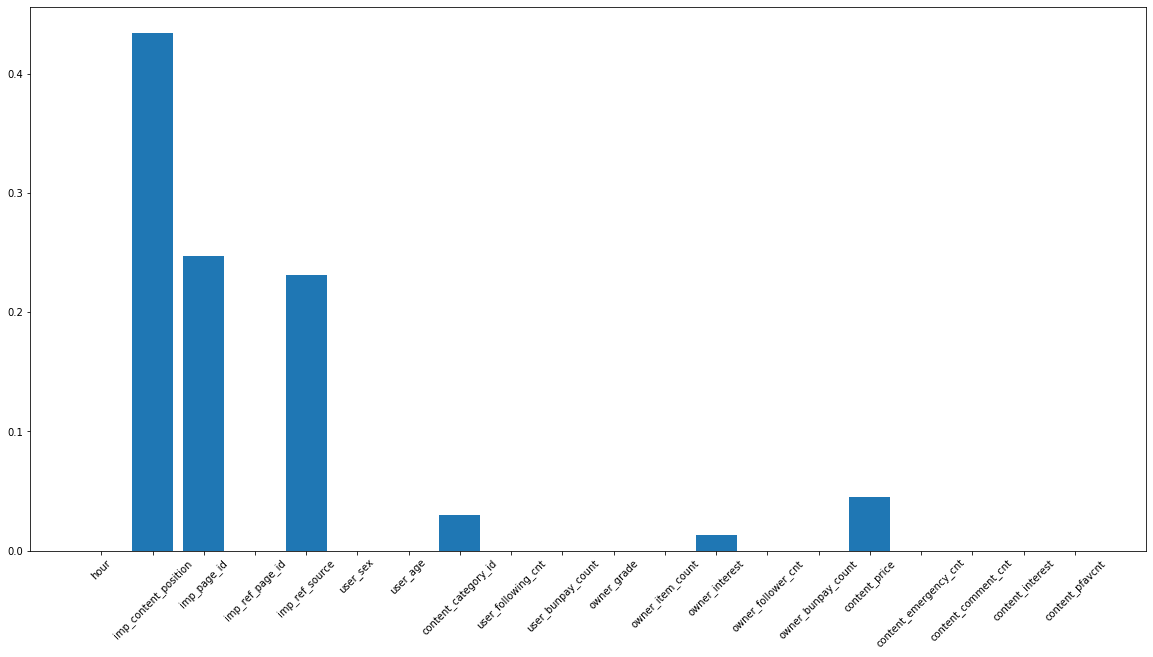

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(features, best_xgb.feature_importances_)
plt.xticks(rotation=45)

### Logistic Regression

In [15]:
param_space = {
    'class_weight': [{0:1, 1:i} for i in range(20)]
}
lr = LogisticRegression(n_jobs=-1, random_state=42)
lr_random_search = RandomizedSearchCV(lr, param_space, return_train_score=True, scoring='neg_log_loss',
                                      verbose=True, cv=5, n_jobs=-1, random_state=42)
lr_random_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.6min
/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=-1,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 0},
                                                         {0: 1, 1: 1},
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 3},
   

In [16]:
print('best parameters:')
print(lr_random_search.best_params_)
best_lr = lr_random_search.best_estimator_.fit(x_train, y_train)
lr_pred = best_lr.predict(x_test)
lr_click_proba = best_lr.predict_proba(x_test)[:, 1]

best parameters:
{'class_weight': {0: 1, 1: 1}}


In [18]:
print('log loss:', log_loss(y_test.astype(int), lr_click_proba))
print('brier_score_loss:', brier_score_loss(y_test, lr_click_proba))
print('RIG:', rig(lr_click_proba, [len([i for i in y_test if i == 1])/len(y_test)]*len(lr_click_proba)))

log loss: 0.1808750239093828
brier_score_loss: 0.034782216854153704
RIG: 0.9515875032132436


In [ ]:
f = open('./test.txt', 'w')
f.write([1,2,3])